In [ ]:
from stand_da import compute_p_value, generate_data, AD_DA
from model import WDGRL, AutoEncoder
import torch
import numpy as np
import scipy
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [3]:
ns, nt, d = 50, 25, 10
alpha = 0.05

mu_s = 0
mu_t = 2
delta_s = [0, 0.5, 1, 1.5, 2]
delta_t = [0] # No true outliers

In [4]:
generator_hidden_dims = [50, 10]
critic_hidden_dims = [10]
wdgrl = WDGRL(input_dim=d, generator_hidden_dims=generator_hidden_dims, critic_hidden_dims=critic_hidden_dims)
index = None

with open("model/wdgrl_models.txt", "r") as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        words = line[:-1].split("/")
        if words[1] == str(generator_hidden_dims) and words[2] == str(critic_hidden_dims):
            index = i
            break
        
if index is None:
    print("Error: WDGRL Model not found wdgrl")

check_point = torch.load(f"model/wdgrl_{index}.pth", map_location=wdgrl.device, weights_only=True)
wdgrl.generator.load_state_dict(check_point['generator_state_dict'])
wdgrl.critic.load_state_dict(check_point['critic_state_dict'])
wdgrl.generator = wdgrl.generator.double()


In [5]:
input_dim = generator_hidden_dims[-1]
encoder_hidden_dims = [input_dim, 8, 4, 2]
decoder_hidden_dims = [2, 4, 8, input_dim]
ae = AutoEncoder(input_dim=input_dim, encoder_hidden_dims=encoder_hidden_dims, decoder_hidden_dims=decoder_hidden_dims)
index = None

with open("model/ae_models.txt", "r") as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        words = line[:-1].split("/")
        if words[1] == str(input_dim) and words[2] == str(encoder_hidden_dims) and words[3] == str(decoder_hidden_dims):
            index = i
            break

if index is None:
    print("Error: AE model not found")
check_point = torch.load(f"model/ae_{index}.pth", map_location=ae.device, weights_only=True)
ae.load_state_dict(check_point['state_dict'])
ae = ae.double()

In [ ]:
max_iteration = 120
Alpha = 0.05

list_p_value = []
for i in range(max_iteration):
    Xs, ys, sigma_s = generate_data(mu_s, delta_s, ns, d)
    Xt, yt, sigma_t = generate_data(mu_t, delta_t, nt, d)
    
    O = AD_DA(Xs, Xt, wdgrl, ae, alpha=alpha)
    
    if len(O) == 0 or len(O) == nt:
        continue
    j = np.random.choice(O)
    
    p_value = compute_p_value(Xs, Xt, sigma_s, sigma_t, wdgrl, ae, j, O, alpha)
    
    if p_value is None:
        continue
    list_p_value.append(p_value)
    


FPR: 0.05
Uniform Check (KS test): 0.6699274119369442


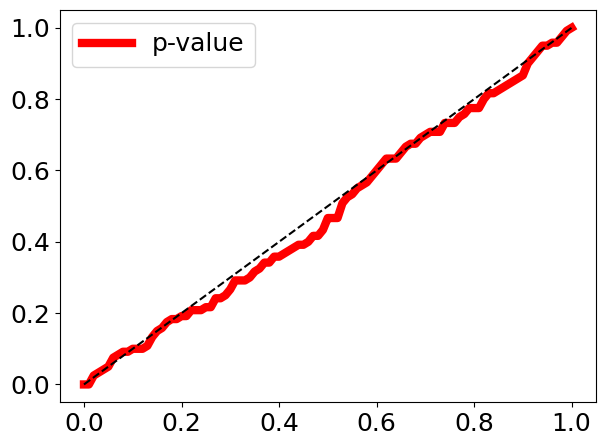

In [14]:
detected = 0
rejected = 0

for p_value in list_p_value:
    if p_value <= Alpha:
        detected += 1
    else:
        rejected += 1

FPR = detected / (detected + rejected) 
kstest = scipy.stats.kstest(list_p_value, 'uniform', args=(0, 1))

print(f"FPR: {FPR}")
print(f"Uniform Check (KS test): {kstest.pvalue}")
plt.rcParams.update({'font.size': 18})
grid = np.linspace(0, 1, 101)
plt.plot(grid, sm.distributions.ECDF(np.array(list_p_value))(grid), 'r-', linewidth=6, label='p-value')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.tight_layout()
plt.show()